Agrupamento
===========



## Importações



In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

Parte deste notebook usa o módulo `kneed`. O código abaixo instala ele caso ele não esteja instalado.



In [2]:
try:
    import kneed

except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install kneed

## Introdução



Agrupamento é uma estratégia de aprendizado não-supervisionado onde um algoritmo identifica grupos de dados que (de certa maneira) são similares entre si [1]. O termo *clustering* em inglês é muitas vezes utilizado mesmo na literatura nacional para se referir a agrupamento.

Por se tratar de uma estratégia de aprendizado *não-supervisionado*, não utilizaremos os targets para treinar os modelos que veremos abaixo. Logo, os algoritmos deverão encontrar padrões de agrupamento sem o conhecimento prévio do target.

Uma vantagem de termos um modelo que agrupa dados não-rotulados (isto é, dados sem o target) é que podemos estudar os grupos de dados isoladamente em busca de padrões (análise exploratória).

Outra vantagem é que os dados agrupados podem ser utilizados para treinar modelos supervisionados especialistas. Um modelo especialista que observa apenas dados de um certo grupo pode ser mais simples e mais eficaz em identificar padrões deste grupo. Este é o princípio do *aprendizado semi-supervisionado*. **Exemplo**: um clustering de ligas metálicas pode resultar em três grupos distintos de ligas, em cada grupo podemos treinar uma árvore de decisão para prever alguma propriedade de interesse.

Existem diversos algoritmos disponíveis para agrupamento, muitos deles já implementados no `scikit-learn`. A imagem abaixo e o código para gerar esta imagem podem ser conferidos na Ref. [2]. Cada coluna do gráfico representa um algoritmo diferente de agrupamento e cada linha representa um conjunto de dados diferente. Em especial, o conjunto de dados da última linha é apenas um conjunto aleatória de pontos onde não deveríamos encontrar grupos (qualquer grupo encontrado é um padrão espúrio encontrado pelos algoritmos). Veremos alguns destes algoritmos neste notebook e o restante pode ser consultado em detalhes em livros, vídeos e na documentação do `scikit-learn` [3].

![img](https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png)



## Agrupamento $k$​-médias



### O algoritmo



O algoritmo de $k$​-médias (*$k$​-means* em inglês) é provavelmente o algoritmo de agrupamento mais conhecido e utilizado. Os passos para utilizar este algoritmo são:

1.  Identifique quais são os dados que quer agrupar (geralmente são os atributos do problema de interesse). Registre a dimensionalidade dos dados na variável $d$ (isto é, armazene na variável $d$ o número de atributos do seu conjunto de dados);

2.  Escolha o número $k$ de grupos que você deseja identificar;

3.  Sorteie $k$ pontos de $d$ dimensões. Uma estratégia razoável aqui é sortear $k$ exemplos diferentes do seu conjunto de dados identificado no passo 1 pois cada um destes pontos terá $d$ dimensões. Vamos chamar cada um dos $k$ pontos sorteados de *centroide*;

4.  Para cada exemplo do conjunto de dados (ver passo 1), identifique qual é o centroide mais próximo utilizando alguma métrica de distância (distância Euclidiana é uma escolha comum);

5.  Os dados agora devem estar separados em grupos com relação ao centroide mais próximo. Para cada um destes grupos de dados, compute um novo centroide utilizando apenas os dados do grupo.

6.  Compare os centroides originais com os centroides calculados no passo 5. Caso não tenha observado alteração significativa dos centroides, então encerre o algoritmo e retorne os centroides calculado no passo 5. Do contrário, armazene os centroides do passo 5 na variável $k$ e retorne para o passo 4.

Para computar o centroide $\mathbf{C}$ de um conjunto de pontos, basta usar a fórmula

$$
\mathbf{C} = \frac{\mathbf{x}_1 + \mathbf{x}_2 + \cdots + \mathbf{x}_k}{k},
$$

onde cada $\mathbf{x}_i$ é um ponto do conjunto (todos eles com dimensão $\mathbb{R}^n$)



### Visualizando o $k$​-médias



[Este site](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/) tem uma ferramenta interativa que pode ajudar a visualizar os passos do algoritmo $k$-médias [6].



### $k$​-médias com `scikit-learn`



Primeiramente precisamos de dados. Vamos criar dados sintéticos agrupados utilizando a função `make_blobs`.



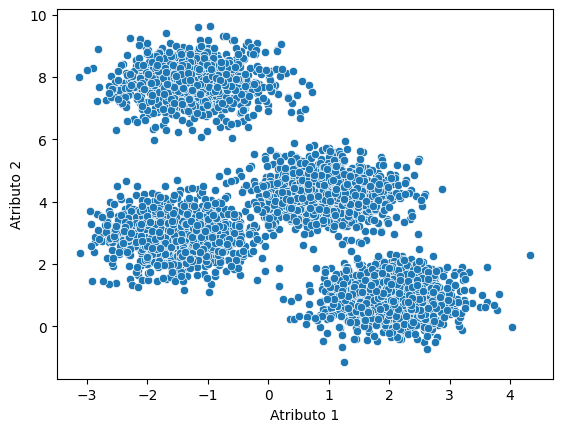

In [3]:
SEMENTE_ALEATORIA = 0

NUM_PONTOS = 4000
NUM_CENTROS = 4
DESVIO_PADRAO = 0.6

X, y = datasets.make_blobs(
    n_samples=NUM_PONTOS,
    centers=NUM_CENTROS,
    cluster_std=DESVIO_PADRAO,
    random_state=SEMENTE_ALEATORIA,
)

sns.scatterplot(x=X[:, 0], y=X[:, 1])
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2");

Para usar o agrupador $k$​-médias, primeiro criamos uma instância do agrupador, rodamos o método `fit` nos dados e coletamos os rótulos obtidos do atributo `labels_`.

**Nota**: o argumento `n_init` representa o número de vezes que o algoritmo do $k$-médias vai rodar para buscar a convergência. Na versão do `scikit-learn` que este notebook está sendo testado, o módulo da um aviso caso você não coloque um valor para este argumento. Por isso coloquei o valor `"auto"` que é para dizer ao módulo buscar este valor automaticamente.



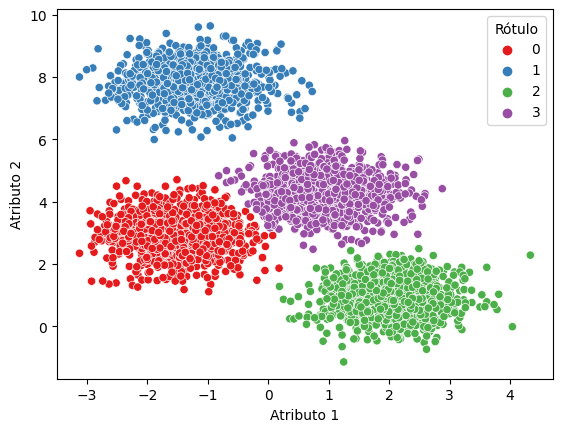

In [4]:
from sklearn.cluster import KMeans

NUM_GRUPOS = 4

agrupador = KMeans(
    n_clusters=NUM_GRUPOS, random_state=SEMENTE_ALEATORIA, n_init="auto"
)

agrupador.fit(X)

rotulos = agrupador.labels_

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=rotulos, palette="Set1")
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2")
plt.legend(title="Rótulo");

### Como escolher o valor de $k$?



No passo 2 do algoritmo nós definimos o valor $k$ do número de grupos que queremos identificar. Mas como escolher um bom valor de $k$?

Existe um método muito utilizado chamado de *método do cotovelo* (elbow method) que pode nos dar uma pista de qual é um bom valor de $k$ para utilizarmos. No entanto, mesmo sendo muito utilizado e recomendado, <u>uma publicação recente apresenta evidências que este método na verdade não é muito bom</u> [4]. Por este motivo, não vamos investigar este método aqui.

Uma estratégia melhor para encontrarmos um bom valor de $k$ é utilizar a métrica de Calinski-Harabasz (também conhecido como *critério da razão da variância*) [5]. <u>Quanto maior for esta métrica, melhor!</u>

Para testarmos, precisamos de dados. Vamos usar os dados que geramos na seção anterior.



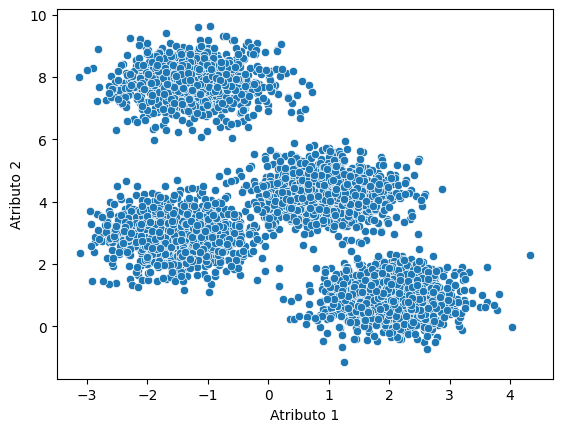

In [5]:
sns.scatterplot(x=X[:, 0], y=X[:, 1])
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2");

Vamos investigar como estes dados se comportam ao variarmos o valor de $k$.



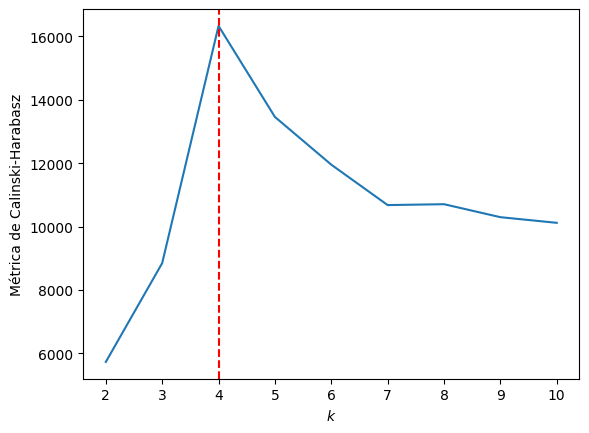

In [6]:
from sklearn.metrics import calinski_harabasz_score

VALORES_DE_K = range(2, 11)
metricas = []

for k in VALORES_DE_K:
    agrupador = KMeans(
        n_clusters=k, random_state=SEMENTE_ALEATORIA, n_init="auto"
    )
    agrupador.fit(X)
    rotulos = agrupador.labels_
    metrica = calinski_harabasz_score(X, rotulos)
    metricas.append(metrica)

indice_max = metricas.index(max(metricas))

sns.lineplot(x=VALORES_DE_K, y=metricas)
plt.axvline(VALORES_DE_K[indice_max], linestyle="--", color="red")
plt.xlabel("$k$")
plt.ylabel("Métrica de Calinski-Harabasz");

A formulação matemática da métrica de Calinski-Harabasz está fora do escopo deste notebook, mas você pode checar na Ref. [5].

Para mais informações sobre como escolher o valor de $k$, veja a Ref. [8].



### Alguns pontos a serem considerados



Os pontos abaixo foram levantados pelo Prof. Francisco Rodrigues no vídeo da Ref. [7].

1.  Os agrupamentos identificados pelo $k$​-médias são dependentes dos primeiros centroides escolhidos no passo 3 do algoritmo. Desta forma, uma estratégia válida é executar este algoritmo diversas vezes em busca de entender qual é o agrupamento (isto é, conjunto de centroides) mais frequente. **Nota**: o `scikit-learn` já faz isso;

2.  O algoritmo apresenta problemas quando os grupos têm tamanhos muito diferentes;

3.  O algoritmo apresenta problemas quando os grupos têm densidades muito diferentes;

4.  O algoritmo apresenta problemas quando os grupos são globulares (veja os gráficos das duas primeiras linhas da primeira coluna da introdução). Para este tipo de dados, veja o algoritmo DBSCAN abaixo.



## Agrupamento DBSCAN



### O algoritmo



O algoritmo de Agrupamento Espacial Baseado em Densidade de Registros com Ruído (*Density-based spatial clustering of applications with noise* ou simplesmente DBSCAN) é um algoritmo de agrupamento baseado em densidade. Os passos para utilizar este algoritmo são:

1.  Identifique quais são os dados que quer agrupar (geralmente são os atributos do problema de interesse);

2.  Defina um valor $\varepsilon$ positivo e diferente de zero. Este valor será o *raio da vizinhança* da busca do DBSCAN. Dizemos que um exemplo está na vizinhança de outro exemplo se a distância entre eles for menor ou igual a $\varepsilon$ (a distância Euclidiana é uma escolha possível para computar esta distância, mas podemos escolher outras);

3.  Defina um valor $N$ inteiro positivo e diferente de zero. Este valor será o número mínimo de vizinhos para um ponto ser um considerado um *ponto central* (definição no próximo passo);

4.  Para cada exemplo no conjunto de dados, classifique ele da seguinte maneira:
    -   **ponto central**: caso existam $x \geq N$ pontos na vizinhança do exemplo (incluindo o próprio exemplo);
    
    -   **ponto de borda**: caso existam $x < N$ pontos na vizinhança do exemplo, porém o exemplo em si faz parte da vizinhança de um ponto central;
    
    -   **ponto anômalo**: caso existam $x < N$ pontos na vizinhança do exemplo e o exemplo não faz parte da vizinhança de um ponto central.

5.  Defina o valor $r = 0$;

6.  Escolha um ponto central qualquer e atribua para ele o rótulo $r$;

7.  Identifique todos os pontos centrais na vizinhança do ponto escolhido no último passo que realizou e atribua para eles o rótulo $r$;

8.  Repita o passo 7 para cada ponto central que receber o rótulo $r$;

9.  Realize a operação $r \leftarrow r + 1$ (isto é, armazene na variável $r$ o valor atual de $r$ somado com 1);

10. Escolha um ponto central qualquer que não tenha sido rotulado até agora. Se este ponto existir, atribua o rótulo $r$ para ele e volte para o passo 7. Se todos os pontos centrais já tiverem um rótulo, então vá ao passo 11;

11. Rotule cada ponto de borda com o rótulo $r$ do seu ponto central mais próximo;

12. Rotule cada ponto anômalo com o rótulo $-1$.

O processo todo está muito bem explicado no vídeo da Ref. [9].



### Visualizando o DBSCAN



[Este site](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/) tem uma ferramenta interativa que pode ajudar a visualizar os passos do algoritmo DBSCAN [10].



### DBSCAN com `scikit-learn`



Primeiramente precisamos de dados. Vamos criar dados sintéticos agrupados utilizando a função `make_circles`.



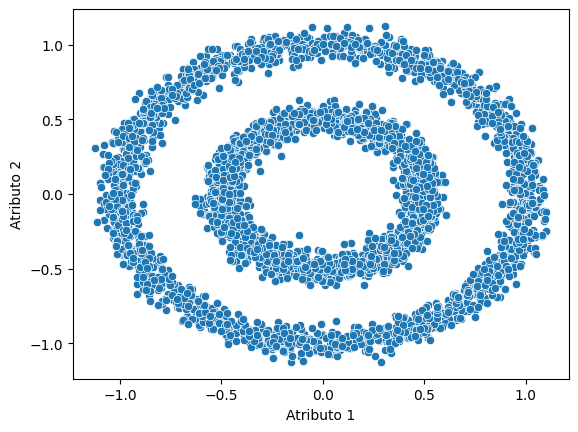

In [7]:
NUM_PONTOS = 4000
FATOR = 0.5
RUIDO = 0.05

X, y = datasets.make_circles(
    n_samples=NUM_PONTOS,
    factor=FATOR,
    noise=RUIDO,
    random_state=SEMENTE_ALEATORIA,
)

sns.scatterplot(x=X[:, 0], y=X[:, 1])
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2");

Para usar o agrupador DBSCAN, primeiro criamos uma instância do agrupador, rodamos o método `fit` nos dados e coletamos os rótulos obtidos do atributo `labels_`. Os rótulos com valor `-1` são rótulos dos valores anômalos identificados (outliers).



Número de grupos identificados: 2
Número de exemplos anômalos (outliers) indentificados: 0


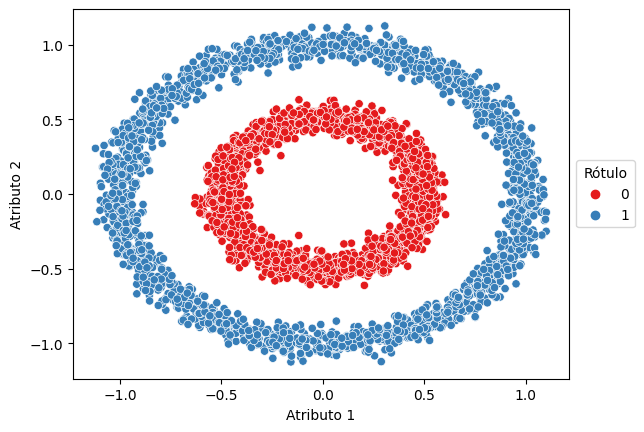

In [8]:
from sklearn.cluster import DBSCAN

RAIO_VIZINHANCA = 0.1
NUM_MIN_VIZINHOS = 3

agrupador = DBSCAN(eps=RAIO_VIZINHANCA, min_samples=NUM_MIN_VIZINHOS)

agrupador.fit(X)

rotulos = agrupador.labels_

n_outliers = list(rotulos).count(-1)
n_grupos = len(set(rotulos))

if n_outliers > 0:
    n_grupos = n_grupos - 1

print(f"Número de grupos identificados: {n_grupos}")
print(f"Número de exemplos anômalos (outliers) indentificados: {n_outliers}")

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=rotulos, palette="Set1")
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2")
plt.legend(title="Rótulo", loc="center left", bbox_to_anchor=(1, 0.5));

### Como escolher os valores de $\varepsilon$ e $N$?



Escolher bons valores de $\varepsilon$ e $N$ não é trivial. É comum encontrar textos dizendo que são escolhas que dependem do conhecimento do domínio de estudo de onde os dados foram coletados.

Em um contexto de aprendizado de máquina supervisionado, uma estratégia é considerar estes valores como hiperparâmetros do seu pipeline e otimizá-los por <u>validação cruzada</u> (isto é, deixe que o processo de otimização de hiperparâmetros por validação cruzada encontre os melhores valores para estes parâmetros).

Um *palpite inicial* para o parâmetro $N$ é considerar o dobro do número de atributos que você tem. Se tem 3 atributos, então um palpite inicial para $N$ seria 6.

Um palpite para o $\varepsilon$ pode ser obtido com a função abaixo.



In [9]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator


def gera_palpite_raio_vizinhanca(X, N):
    """Método para palpite do raio de vizinhança

    Args:
      X: conjunto de dados (atributos).
      N: número minimo de vizinhos do DBSCAN.

    Returns:
      Valor sugerido do raio da vizinhança.

    References:
      Código modificado de https://stackoverflow.com/a/71468901.
    """

    modelo = NearestNeighbors(n_neighbors=N + 1)
    modelo.fit(X)

    distancias, _ = modelo.kneighbors(X)
    distancias = np.sort(distancias, axis=0)
    distancias = distancias[:, N]

    cotovelo = KneeLocator(
        np.arange(len(distancias)),
        distancias,
        curve="convex",
        direction="increasing",
        interp_method="polynomial",
    )

    cotovelo.plot_knee()
    plt.xlabel("Quantidade de pontos")
    plt.ylabel("Distância")

    palpite_raio = distancias[cotovelo.knee]

    print(f"O palpite para o raio da vizinhança é {palpite_raio}")

    return palpite_raio

Vamos ver esta função em ação.



O palpite para o raio da vizinhança é 0.035218057604695714


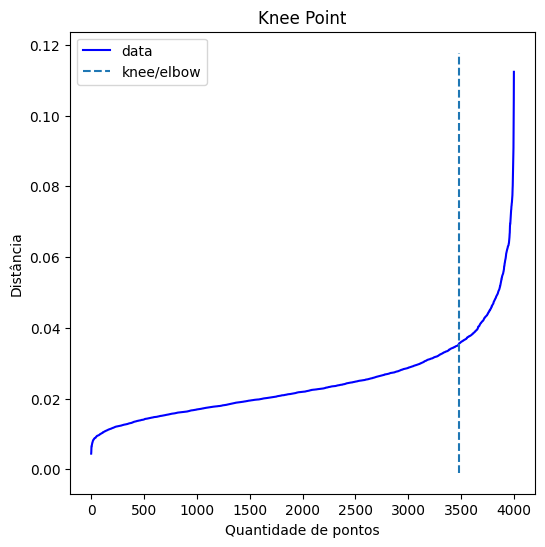

In [10]:
num_atributos = X.shape[-1]

palpite_num_min_vizinhos = 2 * num_atributos

palpite_raio_vizinhanca = gera_palpite_raio_vizinhanca(
    X, palpite_num_min_vizinhos
)

Vamos observar como os palpites se comportam com os dados que estamos estudando.



Número de grupos identificados: 10
Número de exemplos anômalos (outliers) indentificados: 157


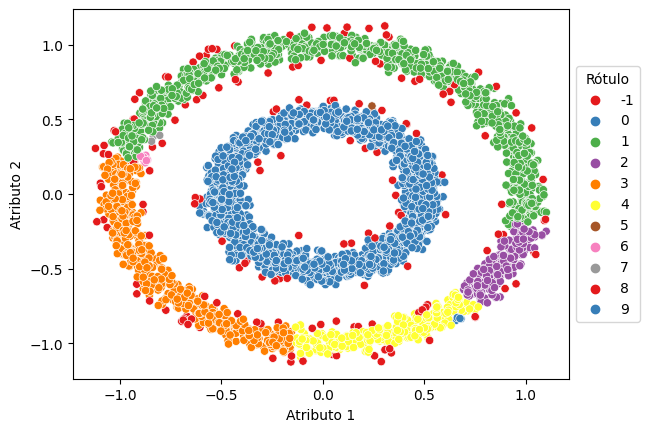

In [11]:
RAIO_VIZINHANCA = palpite_raio_vizinhanca
NUM_MIN_VIZINHOS = palpite_num_min_vizinhos

agrupador = DBSCAN(eps=RAIO_VIZINHANCA, min_samples=NUM_MIN_VIZINHOS)

agrupador.fit(X)

rotulos = agrupador.labels_

n_outliers = list(rotulos).count(-1)
n_grupos = len(set(rotulos))

if n_outliers > 0:
    n_grupos = n_grupos - 1

print(f"Número de grupos identificados: {n_grupos}")
print(f"Número de exemplos anômalos (outliers) indentificados: {n_outliers}")

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=rotulos, palette="Set1")
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2")
plt.legend(title="Rótulo", loc="center left", bbox_to_anchor=(1, 0.5));

Observe que não ficou excelente, vamos alterar um pouco o palpite do raio da vizinhança e ver o que acontece.



Número de grupos identificados: 2
Número de exemplos anômalos (outliers) indentificados: 108


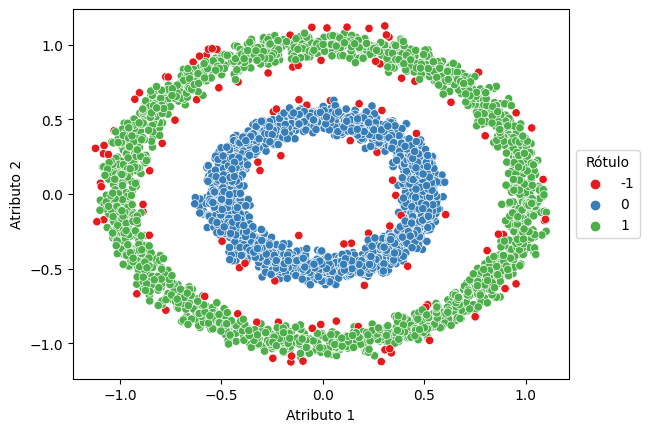

In [12]:
RAIO_VIZINHANCA = 0.04
NUM_MIN_VIZINHOS = palpite_num_min_vizinhos

agrupador = DBSCAN(eps=RAIO_VIZINHANCA, min_samples=NUM_MIN_VIZINHOS)

agrupador.fit(X)

rotulos = agrupador.labels_

n_outliers = list(rotulos).count(-1)
n_grupos = len(set(rotulos))

if n_outliers > 0:
    n_grupos = n_grupos - 1

print(f"Número de grupos identificados: {n_grupos}")
print(f"Número de exemplos anômalos (outliers) indentificados: {n_outliers}")

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=rotulos, palette="Set1")
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2")
plt.legend(title="Rótulo", loc="center left", bbox_to_anchor=(1, 0.5));

### Alguns pontos a serem considerados



Os pontos abaixo sem referência própria foram retirados da Ref. [11].

1.  O algoritmo apresenta problemas quando os grupos têm densidades muito diferentes;

2.  A distância Euclidiana não é uma boa métrica em problemas com mais de três dimensões. Neste caso, escolha outra medida de distância (uma sugestão é a distância Manhattan);

3.  Escolher um bom valor de $\varepsilon$ e de $N$ não é trivial;

4.  A implementação do DBSCAN do `scikit-learn` é determinística, porém a identificação dos grupos dos pontos de borda depende da ordem dos dados de entrada [12].



## Agrupamento hierárquico



### O algoritmo



Existem diversas estratégias para realizar um agrupamento hierárquico, todas elas baseadas na *matriz de distâncias*. A matriz de distâncias é uma matriz quadrada e simétrica de duas dimensões onde cada linha e cada coluna representa um grupo e o valor de cada elemento da matriz é a distância entre o grupo da respectiva linha e o grupo da respectiva coluna [13, 14].

Existe mais de uma métrica para se computar a distância entre dois grupos. Considere que $\mathrm{C}_1$ e $\mathrm{C}_2$ sejam dois grupos e que cada um destes grupos é um conjunto de um ou mais exemplos. Veja abaixo quatro métricas diferentes (imagens da Ref. [15]).

-   **Distância de ligação mínima**: computa a menor distância entre dois elementos de $\mathrm{C}_1$ e $\mathrm{C}_2$. Também conhecida como *single linkage*. A formulação desta distância é $$d(\mathrm{C}_1, \mathrm{C}_2) = \underset{x_{i}\in \mathrm{C}_{1},x_{j}\in \mathrm{C}_{2}}{\min}(d(x_{i},x_{j}))$$

![img](https://media.geeksforgeeks.org/wp-content/uploads/20190718124314/single2.png)

-   **Distância de ligação máxima**: computa a maior distância entre dois elementos de $\mathrm{C}_1$ e $\mathrm{C}_2$. Também conhecida como *complete linkage*. A formulação desta distância é $$d(\mathrm{C}_1, \mathrm{C}_2) = \underset{x_{i}\in \mathrm{C}_{1},x_{j}\in \mathrm{C}_{2}}{\max}(d(x_{i},x_{j}))$$
    
    ![img](https://media.geeksforgeeks.org/wp-content/uploads/20190719093711/complete5.png)

-   **Distância de ligação média**: computa a distância média entre todos os elementos de $\mathrm{C}_1$ e $\mathrm{C}_2$. Também conhecida como *average linkage*. Sendo $n_1$ o número de elementos de $\mathrm{C}_1$ e $n_2$ o número de elementos de $\mathrm{C}_2$, a formulação desta distância é $$d(\mathrm{C}_1, \mathrm{C}_2) = \frac{1}{n_1 n_2} \underset{x_{i}\in \mathrm{C}_{1},x_{j}\in \mathrm{C}_{2}}{\sum}d(x_{i},x_{j})$$

![img](https://media.geeksforgeeks.org/wp-content/uploads/20190718124307/average1.png)

-   **Método da variância mínima de Ward**: neste método, caso a cardinalidade de $\mathrm{C}_1$ e de $\mathrm{C}_2$ seja 1 (isto é, são conjuntos com apenas um elemento), então a distância $d(\mathrm{C}_1, \mathrm{C}_2)$ é simplesmente a distância Euclidiana entre os elementos dos conjuntos. Caso contrário, considere que $n_1$ é o número de elementos de $\mathrm{C}_1$, $n_2$ é o número de elementos de $\mathrm{C}_2$ e $n_3$ é o número de elementos de $\mathrm{C}_3$ e compute a distância de Ward pela formulação:

$$
d(\mathrm{C}_1 \cup \mathrm{C}_2, \mathrm{C}_3) = \frac{n_1 + n_3}{n_1 + n_2 + n_3} d(\mathrm{C}_1, \mathrm{C}_3) + \frac{n_2 + n_3}{n_1 + n_2 + n_3} d(\mathrm{C}_2, \mathrm{C}_3) - \frac{n_3}{n_1 + n_2 + n_3} d(\mathrm{C}_1, \mathrm{C}_2)
$$

Existem duas estratégias para se construir um agrupamento hierárquico:

-   **Estratégia aglomerativa**: cada exemplo em si é considerado um grupo e os exemplos são agrupados entre si sucessivamente até que um grupo contendo todos os exemplos seja formado;

-   **Estratégia divisiva**: todos os exemplos fazem parte de um mesmo grupo e este grupo é dividido sucessivamente até que cada exemplo seja considerado um grupo isolado.

Abaixo está um algoritmo possível para um agrupamento hierárquico que segue a estratégia aglomerativa.

1.  Identifique quais são os dados que quer agrupar (geralmente são os atributos do problema de interesse);

2.  Escolha uma métrica de distância (ligação mínima, ligação média ou ligação máxima, por exemplo);

3.  Defina a distância máxima $d_\mathrm{max}$ para que haja agrupamento;

4.  Considere que cada exemplo do seu conjunto de dados representa um grupo. Armazene estes grupos em um conjunto $G$;

5.  Compute a matriz de distâncias considerando todos grupos do conjunto $G$;

6.  Usando a matriz de distâncias, identifique os dois grupos com a menor distância; chame esta distância de $d$. Caso $d \leq d_\mathrm{max}$, então remova estes dois grupos de $G$, adicione em $G$ um grupo formado pela união destes dois grupos e retorne ao passo 5. Caso $d > d_\mathrm{max}$, então encerre o algoritmo e retorne o conjunto $G$;



### O dendrograma



Uma maneira de visualizar o agrupamento hierárquico é através de um *dendrograma*. Iremos discutir como interpretar um dendrograma durante a aula. Um vídeo para revistar este conceito pode ser visto na Ref. [16].

Vamos criar um conjunto de dados para estudarmos.



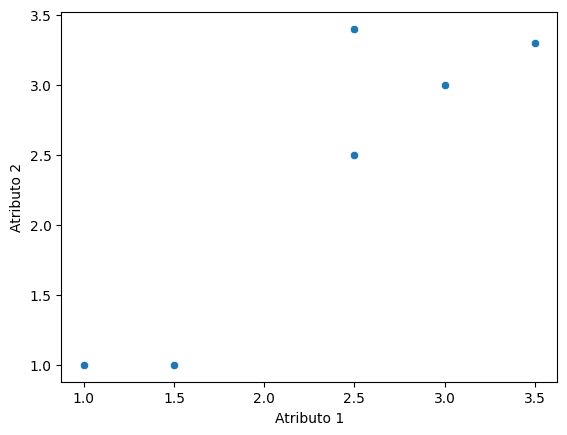

In [13]:
X = np.array([
    [1, 1],
    [1.5, 1],
    [3, 3],
    [3.5, 3.3],
    [2.5, 3.4],
    [2.5, 2.5],
])

sns.scatterplot(x=X[:,0], y=X[:,1])
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2");

O código abaixo gera um dendrograma obtido por agrupamento hierárquico. Neste código você pode alterar a métrica de distância (`METODO_DISTANCIA`) e também o valor de $d_\mathrm{max}$ (`DISTANCIA_MAXIMA`). Um dendrograma mostra no eixo $x$ os dados que temos e no eixo $y$ a distância entre os grupos identificados.



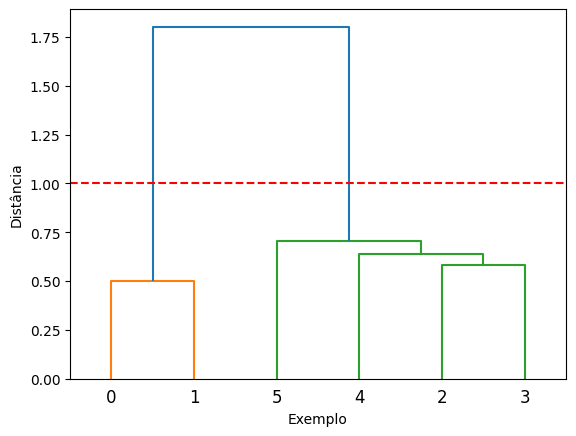

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage

METODO_DISTANCIA = "single"    # distância de ligação mínima
# METODO_DISTANCIA = "complete"  # distância de ligação máxima
# METODO_DISTANCIA = "average"   # distância de ligação média
# METODO_DISTANCIA = "ward"      # distância de variância mínima

DISTANCIA_MAXIMA = 1

matriz_conexoes = linkage(X, METODO_DISTANCIA)

dendrogram(matriz_conexoes)

plt.axhline(DISTANCIA_MAXIMA, linestyle="--", color="red")
plt.xlabel("Exemplo")
plt.ylabel("Distância");

Graficar o dendrograma é uma estratégia interessante para a análise exploratória dos seus dados pois é um gráfico razoavelmente fácil de se interpretar. Do dendrograma, podemos propor palpites para o valor de $d_\textrm{max}$.



### Agrupamento hierárquico com `scikit-learn`



Primeiramente precisamos de dados. Para este exemplo usaremos os dados Iris.



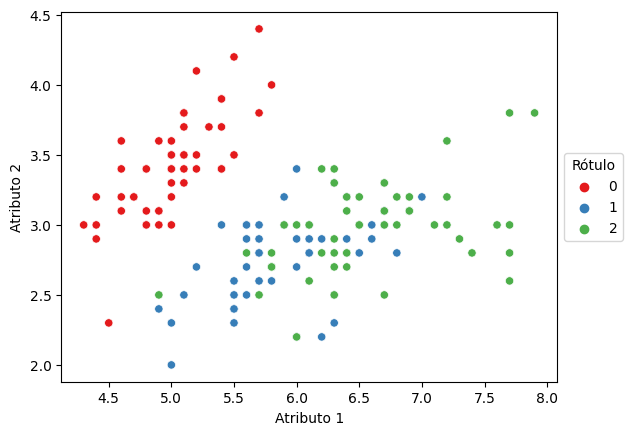

In [15]:
iris = datasets.load_iris()

X = iris.data
y = iris.target

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette="Set1")
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2")
plt.legend(title="Rótulo", loc="center left", bbox_to_anchor=(1, 0.5));

Para usar o agrupador hierárquico, primeiro criamos uma instância do agrupador, rodamos o método `fit` nos dados e coletamos os rótulos obtidos do atributo `labels_`. Podemos deixar o próprio modelo encontrar a distância máxima para separar os dados em um número específico de grupos usando o argumento `n_clusters`.



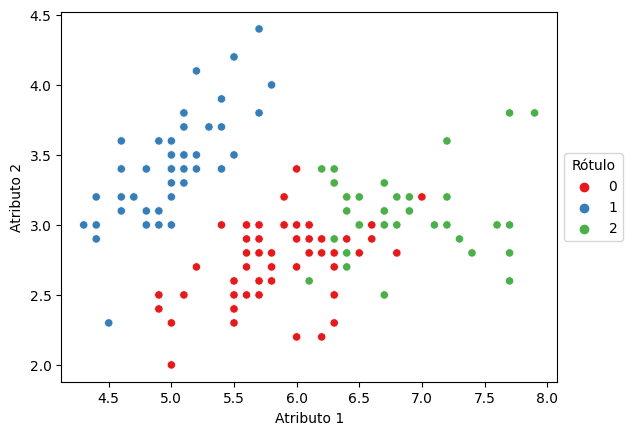

In [16]:
from sklearn.cluster import AgglomerativeClustering

# METODO_DISTANCIA = "single"  # distância de ligação mínima
# METODO_DISTANCIA = "complete"  # distância de ligação máxima
METODO_DISTANCIA = "average"   # distância de ligação média
# METODO_DISTANCIA = "ward"      # distância de variância mínima

NUM_GRUPOS = 3

agrupador = AgglomerativeClustering(
    linkage=METODO_DISTANCIA, n_clusters=NUM_GRUPOS
)

agrupador.fit(X)

rotulos = agrupador.labels_

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=rotulos, palette="Set1")
plt.xlabel("Atributo 1")
plt.ylabel("Atributo 2")
plt.legend(title="Rótulo", loc="center left", bbox_to_anchor=(1, 0.5));

Vamos ver o dendrograma!



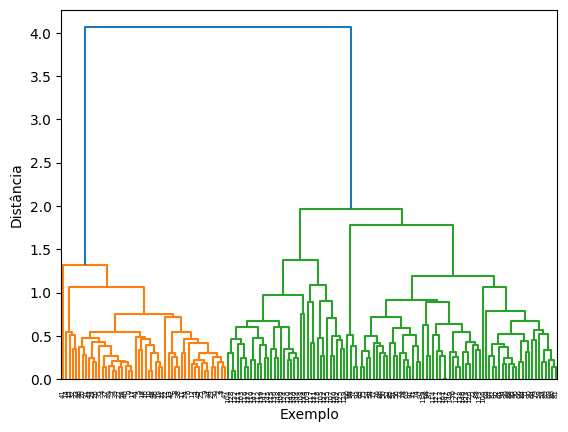

In [17]:
matriz_conexoes = linkage(X, METODO_DISTANCIA)

dendrogram(matriz_conexoes)

plt.xlabel("Exemplo")
plt.ylabel("Distância");

Bastante confuso esse dendrograma&#x2026; temos muitos exemplos e fica difícil de entender o que está acontecendo. Para facilitar a vida, podemos truncar este dendrograma em um número menor de níveis.



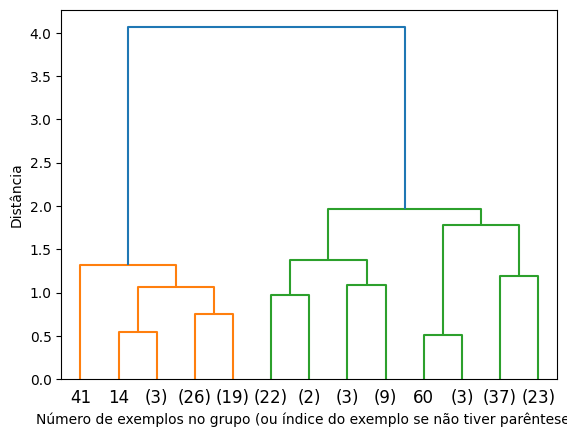

In [18]:
matriz_conexoes = linkage(X, METODO_DISTANCIA)

NIVEL_MAXIMO = 3

dendrogram(matriz_conexoes, truncate_mode="level", p=NIVEL_MAXIMO)

plt.xlabel("Número de exemplos no grupo (ou índice do exemplo se não tiver parênteses)")
plt.ylabel("Distância");

### Alguns pontos a serem considerados



Alguns dos pontos abaixo foram levantados pelo Prof. Francisco Rodrigues no vídeo da Ref. [13].

-   Os resultados do agrupamento hierárquico dependem da métrica de distância escolhida (ligação mínima, ligação média ou ligação máxima, por exemplo);

-   O agrupamento hierárquico é mais adequado para agrupar dados numéricos;

-   O agrupamento hierárquico um método sensível a valores anômalos (outliers);



## XKCD relevante



![img](https://imgs.xkcd.com/comics/k_means_clustering.png)

`Imagem: K-Means Clustering (XKCD) disponível em https://xkcd.com/2731`



## Referências



1.  Agrupamento (Wikipédia) [https://en.wikipedia.org/wiki/Cluster_analysis](https://en.wikipedia.org/wiki/Cluster_analysis)

2.  Comparando algoritmos de agrupamento do `scikit-learn` [https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)

3.  Algoritmos de agrupamento do `scikit-learn` [https://scikit-learn.org/stable/modules/clustering.html](https://scikit-learn.org/stable/modules/clustering.html)

4.  SCHUBERT, Erich. Stop using the elbow criterion for k-means and how to choose the number of clusters instead. ACM SIGKDD Explorations Newsletter, v. 25, n. 1, p. 36–42, 2023.

5.  Métrica de Calinski-Harabasz no `scikit-learn` [https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index](https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index)

6.  $k$​-médias interativo [https://www.naftaliharris.com/blog/visualizing-k-means-clustering/](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/)

7.  Vídeo do Prof. Francisco Rodrigues sobre $k$​-médias [https://www.youtube.com/watch?v=njRYKzRKBPY](https://www.youtube.com/watch?v=njRYKzRKBPY)

8.  Estudo sobre estratégias para escolher o valor de $k$ do $k$​-médias [https://towardsdatascience.com/are-you-still-using-the-elbow-method-5d271b3063bd](https://towardsdatascience.com/are-you-still-using-the-elbow-method-5d271b3063bd)

9.  StatQuest sobre DBSCAN [https://www.youtube.com/watch?v=RDZUdRSDOok](https://www.youtube.com/watch?v=RDZUdRSDOok)

10. DBSCAN interativo [https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)

11. DBSCAN na Wikipédia [https://en.wikipedia.org/wiki/DBSCAN](https://en.wikipedia.org/wiki/DBSCAN)

12. Guia do usuário do `scikit-learn` sobre DBSCAN [https://scikit-learn.org/stable/modules/clustering.html#dbscan](https://scikit-learn.org/stable/modules/clustering.html#dbscan)

13. Vídeo do Prof. Francisco Rodrigues sobre agrupamento hierárquico [https://www.youtube.com/watch?v=zXtMvcgl594](https://www.youtube.com/watch?v=zXtMvcgl594)

14. FACELI, Katti; LORENA, AC; GAMA, João; et al. Inteligência Artificial: uma abordagem de Aprendizado de Máquina. 2. ed. 2021.

15. Visualização das distâncias entre grupos [https://www.geeksforgeeks.org/ml-types-of-linkages-in-clustering/](https://www.geeksforgeeks.org/ml-types-of-linkages-in-clustering/)

16. Vídeo sobre dendrogramas [https://www.youtube.com/watch?v=G_FycSVbvAQ](https://www.youtube.com/watch?v=G_FycSVbvAQ)

